Testing code for validating the base policy

In [1]:
import torch
import torch.nn as nn  # noqa: F401
import numpy as np
from tqdm import tqdm

import safety_gymnasium

from rl_vcf.rl.algos.sac.core import MLPActorCritic
from rl_vcf.rl.utils.make_env import make_env_safety
from rl_vcf.rl.utils.get_actor_structure import get_actor_structure

In [2]:
seed = 0
device = "cuda"
num_envs = 8
envs = safety_gymnasium.vector.SafetySyncVectorEnv(
    [
        make_env_safety(
            "SafetyPointReachAvoidReset1-v0",
            i,
            seed + i,
            False,
            5,
            False,
        )
        for i in range(num_envs)
    ]
)

In [3]:
# Load state dict
loaded_state_dict = torch.load(
    "../torch/test_policy.pt", weights_only=True, map_location=device
)

# Construct agent from state dict
loaded_hidden_sizes, loaded_activation = get_actor_structure(
    loaded_state_dict, envs.single_observation_space, envs.single_action_space
)

agent = MLPActorCritic(
    envs.single_observation_space,
    envs.single_action_space,
    loaded_hidden_sizes,
    eval("nn." + loaded_activation + "()"),
)
agent.pi.load_state_dict(loaded_state_dict, strict=True)
agent.to(device)

# Prevent storing gradients
for p in agent.parameters():
    p.requires_grad = False

In [ ]:
from typing import Container
from logging import warning


class ScenarioDatabase:
    """A class for storing and updating a scenario database."""

    def __init__(
        self, num_envs: int, max_episode_length: int, num_scenarios: int
    ) -> None:
        self.num_envs = num_envs
        self.max_episode_length = max_episode_length
        self.num_scenarios = num_scenarios
        self.reset()

    def reset(self) -> None:
        """Reset the scenario database."""
        self.scenario_data = np.full(
            (self.num_scenarios, self.max_episode_length + 1), False, dtype=bool
        )
        self.active_scenarios = np.arange(self.num_envs, dtype=int)
        self.timesteps = np.zeros(self.num_envs, dtype=int)

    def update(self, done: Container[bool], goal_achieved: Container[bool]) -> None:
        """Update the scenario database."""
        # For each active scenario, check task status
        if not any(self.active_scenarios < self.num_scenarios):
            warning(
                "All scenarios have already been collected; this update will be ignored."
            )
        else:
            for p_idx in range(self.num_envs):
                # If the scenario is to be collected
                if self.active_scenarios[p_idx] < self.num_scenarios:
                    # If the task is done:
                    if done[p_idx]:
                        # If the task is done because the goal was achieved, mark the task as successful
                        if goal_achieved[p_idx]:
                            # On scenario task success, mask current and future time steps as task success
                            # (Assumes reach-avoid task with no consideration of failure after success)
                            self.scenario_data[self.active_scenarios[p_idx]][
                                self.timesteps[p_idx] :
                            ] = True
                        # else, the task was not successful (violated a constraint, or ran out of time)
                        # The scenario pointer now tracks next scenario
                        self.active_scenarios[p_idx] = np.max(self.active_scenarios) + 1
                        # Reset the time step for the next scenario
                        self.timesteps[p_idx] = 0
                    else:
                        # If scenario is ongoing, increment pointer time step
                        self.timesteps[p_idx] += 1

    def get_num_successes(self) -> int:
        """Get the number of successes in the scenario database by each timestep."""
        return self.scenario_data.sum(axis=0)

    def get_num_failures(self) -> int:
        """Get the number of failures in the scenario database by each timestep."""
        return np.logical_not(self.scenario_data).sum(axis=0)

In [191]:
max_episode_length = 1000
N = 1000
# Initialize scenario information database
scenario_database = ScenarioDatabase(num_envs, max_episode_length, N)

In [192]:
print(scenario_database.active_scenarios)
print(scenario_database.timesteps)
print(scenario_database.scenario_data[1][999:])
print(max(scenario_database.active_scenarios))

[0 1 2 3 4 5 6 7]
[0 0 0 0 0 0 0 0]
[False False]
7


In [200]:
# ---
# TESTING:
# This is where task success flags for the active scenarios are found
goal_achieved = np.full(num_envs, False, dtype=bool)
# This is where the done flags are found
done = np.full(num_envs, False, dtype=bool)

# Randomly generate task success flags
p_goal = 0.01
# Randomly generate done flags (term | trunc)
p_done = 0.0002
# ---

# VALIDATION LOOP:

# Instantiate progress bar
pbar = tqdm(total=scenario_database.num_scenarios)
# While we haven't collected all required scenarios
while any(scenario_database.active_scenarios < scenario_database.num_scenarios):
    # ---
    # TESTING: environment step (and goal achieved reasoning) will go here
    # Randomly generate done flag (represents constraint violation)
    done = np.random.rand(num_envs) < p_done
    # Randomly generate goal flag (represents goal achievement)
    goal_achieved = np.random.rand(num_envs) < p_goal
    # If the goal was achieved, mark the task as done
    done = done | goal_achieved
    # ---

    previous_active_scenarios = scenario_database.active_scenarios.copy()

    # If the scenario has reached the max episode length, mark as done
    scenario_database.update(done, goal_achieved)

    num_scenarios_complete = sum(
        previous_active_scenarios != scenario_database.active_scenarios
    )
    pbar.update(num_scenarios_complete)

    # ---
    goal_achieved = np.full(num_envs, False, dtype=bool)
    done = np.full(num_envs, False, dtype=bool)
    # ---

# Close progress bar
pbar.close()

print(scenario_database.get_num_successes())
print(scenario_database.get_num_failures())

  0%|          | 0/1000 [00:00<?, ?it/s]

[ 14  22  38 ... 980 980 980]
[986 978 962 ...  20  20  20]


In [201]:
print(scenario_database.active_scenarios)
print(scenario_database.timesteps)

[1004 1001 1007 1003 1000 1005 1002 1006]
[0 0 0 0 0 0 0 0]


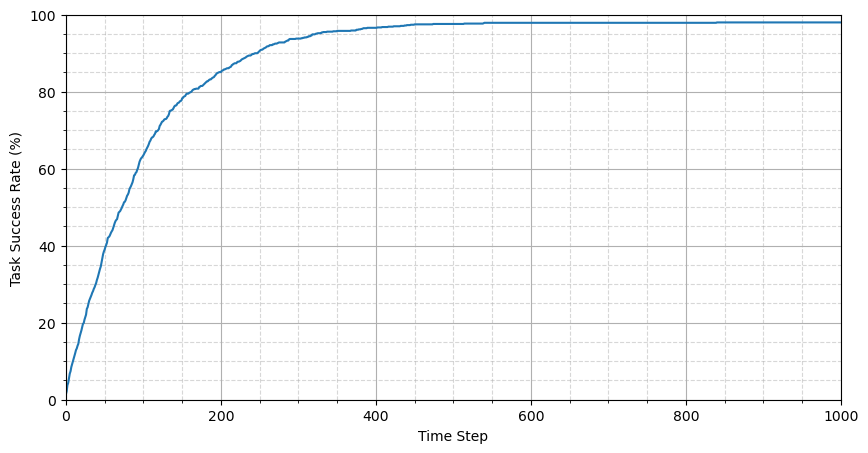

In [202]:
import matplotlib.pyplot as plt

# Plot task success rate
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(scenario_database.get_num_successes() / scenario_database.num_scenarios * 100)
ax.set_xlim([0, max_episode_length])
ax.set_ylim([0, 100])
ax.set_xlabel("Time Step")
ax.set_ylabel("Task Success Rate (%)")
ax.minorticks_on()
ax.grid(which="major")
ax.grid(which="minor", linestyle="--", alpha=0.5)

In [203]:
import math
from concurrent.futures import ProcessPoolExecutor
from typing import Container


def log_binomial_coefficient(N: int, k: int) -> float:
    """
    Compute the logarithm of the binomial coefficient "N choose k".
    """
    if k < 0 or k > N:
        return float("-inf")
    if k == 0 or k == N:
        return 0.0
    return sum(math.log(i) for i in range(N, N - k, -1)) - sum(
        math.log(i) for i in range(1, k + 1)
    )


def estimate_epsilon(
    conf: float,
    N: int,
    k: int,
    it_max: int = 100,
    tol: float = 0.0,
    cutoff: float = 1.0,
) -> float:
    """
    Numerically estimate epsilon for a given confidence level.

    Note that the function returns an upper bound on epsilon.
    """
    # TODO: The binomial coefficient explodes when N is large (somewhere 10000 > N > 1000)
    # as k increases, making numerical estimation impossible.
    # For cases where N is large and k is not small, we will need to settle for less tight bound
    # that is still computationally feasible.

    # Compute beta
    beta = 1.0 - conf

    if k == 0:
        # If there are no violations, we can directly compute epsilon
        return 1.0 - beta ** (1 / N)

    elif k == N:
        # If all scenarios have violations, epsilon is trivially 1
        return 1.0

    elif N <= 1000 and k / N <= cutoff:
        # Numerically compute a tight bound for epsilon, if computationally feasible
        # Uses a divide-and-conquer style approach

        # Initialize epsilon bounds
        eps_lower = 0.0
        eps_upper = 1.0

        # Precompute coefficients
        binom_coeffs = np.array([math.comb(N, i) for i in range(k + 1)])

        # Precompute indices
        indices = np.arange(k + 1)

        for _ in range(it_max):

            # Trial epsilon is midway between current bounds
            eps_trial = (eps_lower + eps_upper) / 2

            # Compute beta for trial epsilon using vectorized operations
            eps_powers = eps_trial**indices
            one_minus_eps_powers = (1 - eps_trial) ** (N - indices)
            beta_trial = np.sum(binom_coeffs * eps_powers * one_minus_eps_powers)

            # If trial beta is lower than target beta, we set the upper bound to the trial epsilon
            if beta_trial <= beta:
                eps_upper = eps_trial
            # Otherwise, we set the lower bound to the trial epsilon
            else:
                eps_lower = eps_trial

            # Early stopping condition
            if eps_upper - eps_lower <= tol:
                break

        return eps_upper

    elif k / N <= cutoff:
        # Numerically compute a tight bound for epsilon, if computationally feasible
        # Uses a divide-and-conquer style approach
        # Puts things in log form for numerical stability

        # Initialize epsilon bounds
        eps_lower = 0.0
        eps_upper = 1.0

        # Precompute coefficients
        log_binom_coeffs = np.array(
            [log_binomial_coefficient(N, i) for i in range(k + 1)], dtype=float
        )
        log_eps_coeffs = np.arange(start=0, stop=k + 1, step=1, dtype=float)
        log_one_minus_eps_coeffs = np.arange(
            start=N, stop=N - k - 1, step=-1, dtype=float
        )

        for _ in range(it_max):

            # Trial epsilon is midway between current bounds
            eps_trial = (eps_lower + eps_upper) / 2

            # Compute beta for trial epsilon using vectorized operations
            log_beta_terms = (
                log_binom_coeffs
                + math.log(eps_trial) * log_eps_coeffs
                + math.log(1 - eps_trial) * log_one_minus_eps_coeffs
            )
            beta_trial = np.sum(np.exp(log_beta_terms))

            # If trial beta is lower than target beta, we set the upper bound to the trial epsilon
            if beta_trial <= beta:
                eps_upper = eps_trial
            # Otherwise, we set the lower bound to the trial epsilon
            else:
                eps_lower = eps_trial

            # Early stopping condition
            if eps_upper - eps_lower <= tol:
                break

        return eps_upper

    else:
        # If numerical computation of a tight bound is not needed,
        # return a loose bound on epsilon (Chernoff bound for Binomial tail)

        return (
            1
            / N
            * (
                (k - math.log(beta))
                + math.sqrt(math.log(beta) * (math.log(beta) - 2 * k))
            )
        )


def estimate_epsilon_parallel(
    conf: float,
    N: int,
    k_values: Container[int],
    it_max: int = 100,
    tol: float = 0.0,
    cutoff: float = 1.0,
) -> list[float]:
    """
    Parallelized epsilon estimation across different values of k using multiprocessing.
    """
    with ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(estimate_epsilon, conf, N, k, it_max, tol, cutoff)
            for k in k_values
        ]
        results = [future.result() for future in futures]
    return results

In [204]:
N_test = 10
k_test = 9
conf_test = 0.95
epsilon_test = estimate_epsilon(conf_test, N_test, k_test)
print(epsilon_test)

0.9948838031081764


In [205]:
# Test numerical result for epsilon

conf = 0.99
k = 3

epsilon = estimate_epsilon(conf, N, k, it_max=100, tol=1e-5)
print(epsilon)

test_beta = sum(
    math.comb(N, i) * (epsilon**i) * ((1 - epsilon) ** (N - i)) for i in range(k + 1)
)
test_conf = 1 - test_beta
print(test_conf)

0.01001739501953125
0.9900560675132372


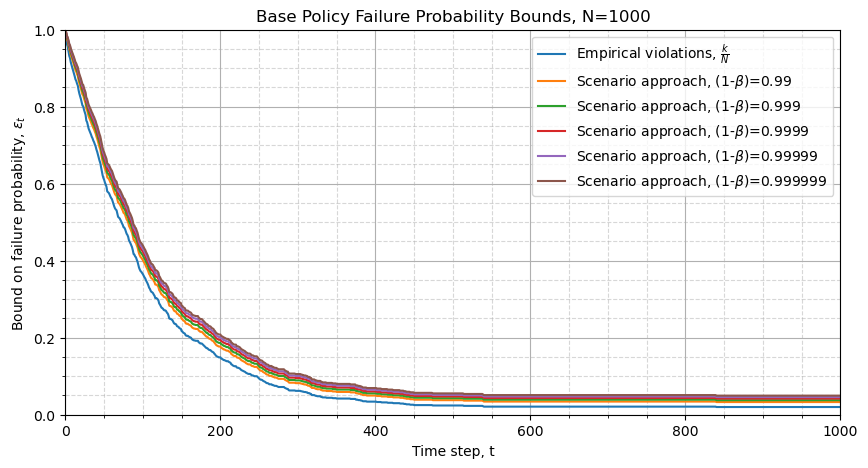

In [207]:
# Plot different methods for computing epsilon
fig, ax = plt.subplots(figsize=(10, 5))

emp_str = r"Empirical violations, $\frac{k}{N}$"
ax.plot(
    (scenario_database.get_num_failures() / scenario_database.num_scenarios),
    label=emp_str,
)
# Note that increasing confidence level takes exponentially longer to compute
confs = [0.99, 0.999, 0.9999, 0.99999, 0.999999]
for conf in confs:
    # Compute bound on failure probability at each time step
    unique_ks = np.unique(scenario_database.get_num_failures())
    epsilon_dict = dict(
        zip(
            unique_ks,
            estimate_epsilon_parallel(
                conf, scenario_database.num_scenarios, unique_ks, tol=1e-5
            ),
        )
    )
    epsilons = np.array([epsilon_dict[k] for k in scenario_database.get_num_failures()])
    scen_str = r"Scenario approach, (1-$\beta$)={f}".format(f=conf)
    ax.plot(epsilons, label=scen_str)
ax.set_xlim([0, max_episode_length])
ax.set_ylim([0, 1])
ax.set_xlabel("Time step, t")
ax.set_ylabel("Bound on failure probability, $\epsilon_{t}$")
ax.minorticks_on()
ax.grid(which="major")
ax.grid(which="minor", linestyle="--", alpha=0.5)
ax.legend()
title_str = f"Base Policy Failure Probability Bounds, N={N}"
ax.title.set_text(title_str)

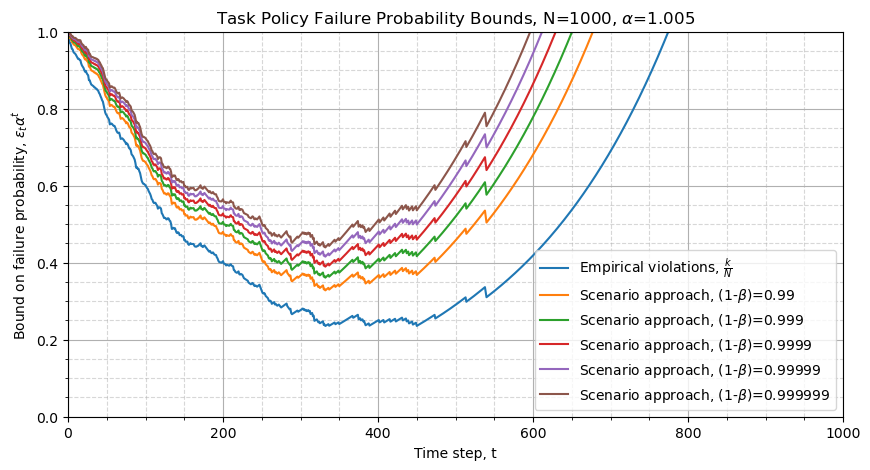

In [208]:
alpha = 1.005

# Plot different methods for computing epsilon
fig, ax = plt.subplots(figsize=(10, 5))

indices = np.arange(max_episode_length + 1)
alphas = alpha**indices

emp_str = r"Empirical violations, $\frac{k}{N}$"
epsilons = scenario_database.get_num_failures() / scenario_database.num_scenarios
epsilons = np.minimum(epsilons * alphas, 1.0)
ax.plot(epsilons, label=emp_str)
confs = [0.99, 0.999, 0.9999, 0.99999, 0.999999]
for conf in confs:
    # Compute bound on failure probability at each time step
    unique_ks = np.unique(scenario_database.get_num_failures())
    epsilon_dict = dict(
        zip(
            unique_ks,
            estimate_epsilon_parallel(
                conf, scenario_database.num_scenarios, unique_ks, tol=1e-5
            ),
        )
    )
    epsilons = np.array([epsilon_dict[k] for k in scenario_database.get_num_failures()])
    epsilons = np.minimum(epsilons * alphas, 1.0)
    scen_str = r"Scenario approach, (1-$\beta$)={f}".format(f=conf)
    ax.plot(epsilons, label=scen_str)
ax.set_xlim([0, max_episode_length])
ax.set_ylim([0, 1])
ax.set_xlabel("Time step, t")
ax.set_ylabel("Bound on failure probability, $\epsilon_{t} \\alpha^{t}$")
ax.minorticks_on()
ax.grid(which="major")
ax.grid(which="minor", linestyle="--", alpha=0.5)
ax.legend()
title_str = f"Task Policy Failure Probability Bounds, N={scenario_database.num_scenarios}, $\\alpha$={alpha}"
ax.title.set_text(title_str)

In [ ]:
# obs, info = envs.reset(seed=[seed + i for i in range(num_envs)])

# with torch.no_grad():  # no gradient needed for testing
#     for global_step in tqdm(range(5)):
#         act = torch.Tensor(
#             np.array([envs.single_action_space.sample() for _ in range(num_envs)])
#         )
#         # act, _ = agent.pi.forward(torch.Tensor(obs).to(device), with_log_prob=False)
#         next_obs, rew, cost, term, trunc, info = envs.step(act.detach().cpu().numpy())
#         obs = next_obs
# print(info)

In [23]:
obs, info = envs.reset(seed=[seed + i for i in range(num_envs)])
print(info)
next_obs, rew, cost, term, trunc, info = envs.step(act.detach().cpu().numpy())
print(info)

{}
{'cost_hazards': array([0., 0., 0., 0.]), '_cost_hazards': array([ True,  True,  True,  True]), 'cost_sum': array([0., 0., 0., 0.]), '_cost_sum': array([ True,  True,  True,  True]), 'constraint_violated': array([False, False, False, False]), '_constraint_violated': array([ True,  True,  True,  True]), 'goal_met': array([False, False, False, False]), '_goal_met': array([ True,  True,  True,  True])}
